## Importing necessary libraries

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from zlib import adler32
from matplotlib.cm import ScalarMappable
import collections
from sklearn.linear_model import LinearRegression

## Preprocessing
I used an api https://vk.com/app3861133 to export friends' graph 

In [2]:
nodes = pd.read_csv('Nodes.csv')
edges = pd.read_csv('Edges.csv')
nodes = nodes.drop(columns=['timeset', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
edges = edges.drop(columns=['Type', 'Id', 'Label', 'timeset', 'Weight'])
#I am 271 index
#my id is 214669066
nodes = nodes.drop([271])
G = nx.Graph()
nodelist = nodes['Id'].tolist()
G.add_nodes_from(nodelist)
edgefrom = edges['Source'].tolist()
edgeto = edges['Target'].tolist()
zipped = zip(edgefrom, edgeto)
zipp = list(zipped)
G.add_edges_from(zipp)
pos = nx.kamada_kawai_layout(G)

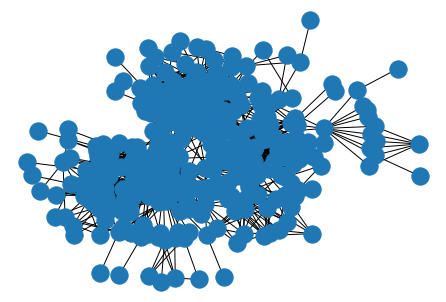

In [3]:
nx.draw(G, pos) 

**Network source and preprocessing** <br>
Node/Edge attributes. <br>
Size, Order. <br>
Diameter, radius. <br>
Clustering Coefficient (global, average local, histogram of locals). <br>
Average path length (+histogram). <br>
Degree distribution, fitting models and coefficient from regression/MLE/KS-test. <br>
Gorgeous network layout. <br>


In [4]:
print(G.size())
print(G.order())

1741
346


In [5]:
connected_component_subgraphs = (G.subgraph(c) for c in nx.connected_components(G))
large = max(connected_component_subgraphs, key=len)
conn = nx.connected_components(G)
len(list(conn))

68

4
7
1715
260


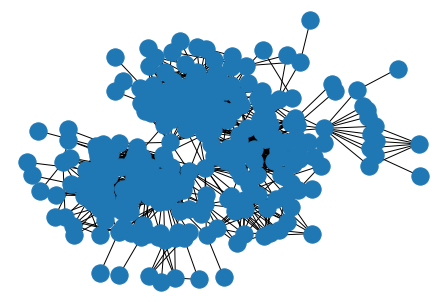

In [6]:
print(nx.radius(large))
print(nx.diameter(large))
nx.draw(large, pos)
print(large.size())
print(large.order())

In [7]:
nx.average_clustering(large)

0.46667693269013455

In [8]:
lcc = nx.clustering(large)

### Histogram of clustering coefficient

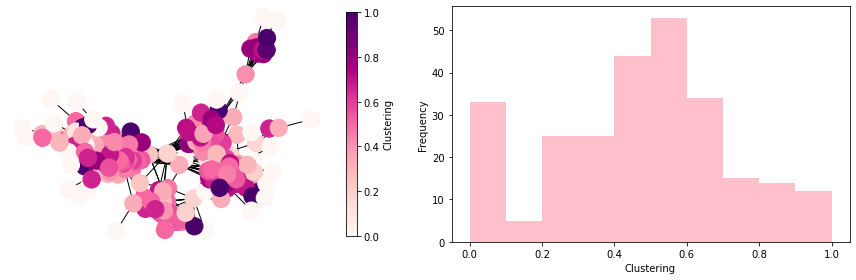

In [9]:
cmap = plt.get_cmap('RdPu')
norm = plt.Normalize(0, max(lcc.values()))
node_colors = [cmap(norm(lcc[node])) for node in large.nodes]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
nx.draw_spring(large, node_color=node_colors, with_labels=False, ax=ax1)
fig.colorbar(ScalarMappable(cmap=cmap, norm=norm), label='Clustering', shrink=0.95, ax=ax1)

ax2.hist(lcc.values(), bins=10, color='pink')
ax2.set_xlabel('Clustering')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Histogram of path lengths

average shortest path length 3.2726331360946745
0 260
1 3430
2 13472
3 22358
4 18636
5 7606
6 1658
7 180


<BarContainer object of 8 artists>

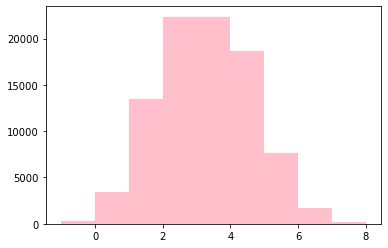

In [10]:
pathlengths = []
for v in large.nodes():
    spl = dict(nx.single_source_shortest_path_length(large, v))
    for p in spl:
        pathlengths.append(spl[p])

print(f"average shortest path length {sum(pathlengths) / len(pathlengths)}")

dist = {}
for p in pathlengths:
    if p in dist:
        dist[p] += 1
    else:
        dist[p] = 1

verts = dist.keys()
for d in sorted(verts):
    print(f"{d} {dist[d]}")
    
plt.bar(dist.keys(), dist.values(), width = 2, color='pink')

### Degree sequence histogram

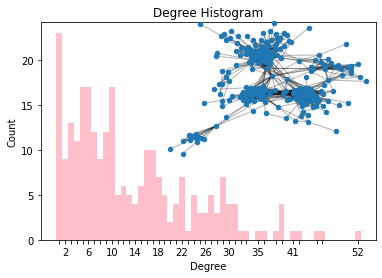

In [11]:
degree_sequence = sorted([d for n, d in large.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=1, color="pink")

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d for d in deg])
ax.set_xticklabels(deg)
every_nth = 4
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
Gcc = G.subgraph(sorted(nx.connected_components(large), key=len, reverse=True)[0])
pos = nx.spring_layout(large)
plt.axis("off")
nx.draw_networkx_nodes(large, pos, node_size=20)
nx.draw_networkx_edges(large, pos, alpha=0.3)
plt.show()

In [12]:
def power_law_cdf(x, alpha=3.5, x_min=1):
    C = (alpha - 1) / x_min ** (1 - alpha)
    return 1 + C * 1/(-alpha + 1) * x ** (-alpha + 1)

In [13]:
def power_law_pdf(x, alpha=3.5, x_min=1):
    C = (alpha - 1) / x_min ** (1 - alpha)
    return C * x ** (-alpha)

### KS-test, MLE params

In [14]:
def mle_power_law_params(degree_sequence):
    import scipy
    x_min_new = 0
    #degree_sequence = (np.sort(np.array(degree_sequence))).astype(int)
    degree_sequence = np.sort(np.array(degree_sequence))
    stats_list = []
    for x in range(1, int(np.max(degree_sequence))):
        xis = degree_sequence[degree_sequence >= x]
        alpha = 1 + len(xis)*np.sum(np.log(xis/x))**(-1)
        if alpha>1:
            stats = scipy.stats.kstest(xis, cdf=power_law_cdf, args=(alpha, x))[0]
            #print(stats)
            p_value = scipy.stats.kstest(xis, cdf=power_law_cdf, args=(alpha, x))[1]
            stats_list.append(stats)
            #print(stats)
            if stats==min(stats_list):
                best_stat = stats
                x_min_new = x
                alpha_new = alpha

    return alpha_new, x_min_new, stats

In [15]:
mle_power_law_params(degree_sequence)

(6.605566887931008, 28, 0.632120558828559)

In [16]:
def power_law_ppf(r, alpha=3.5, x_min=1):
    C = (alpha - 1) / x_min ** (1 - alpha)
    return ((r - 1) / (C * 1/(-alpha + 1))) ** (1 / (-alpha + 1))

In [17]:
def power_law_generate(n, alpha, x_min, random_seed=1):
    np.random.seed(random_seed)
    uni_sample = np.random.uniform(0, 0.999, n)
    return power_law_ppf(uni_sample, alpha, x_min)

In [18]:
def alpha_lin_bins(x_train, bins):
    histogram = np.histogram(x_train, bins)
    density = histogram[0][np.where(histogram[0] != 0)]
    density = np.log(density / len(x_train))
    bin_centres = np.log((histogram[1][1:] + histogram[1][:-1]) / 2)
    bin_centres = bin_centres[np.where(histogram[0] != 0)]
    bin_centres = bin_centres.reshape(-1, 1)
    regression = LinearRegression()
    regression.fit(bin_centres, density)
    return abs(regression.coef_[-1])

In [19]:
bins = 100
x_train = power_law_generate(1741, x_min=28, alpha=6.6)

In [20]:
alpha_lin_bins(x_train, bins)

5.641007539906419

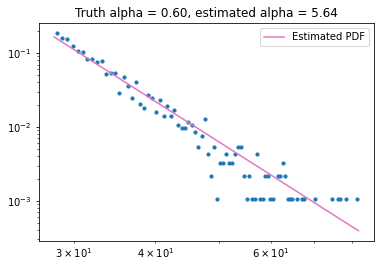

In [21]:
x_min = 28
alpha = 0.6
hist, bin_edges = np.histogram(x_train, bins=bins, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.scatter(bin_centers, hist, s=10)

hat_alpha = alpha_lin_bins(x_train, bins)
x_space = np.linspace(x_min, x_train.max(), 100)
plt.plot(x_space, power_law_pdf(x_space, hat_alpha, x_min), 
         label='Estimated PDF', c='tab:pink')
plt.legend()
plt.title('Truth alpha = {:.2f}, estimated alpha = {:.2f}'.format(alpha, hat_alpha))
plt.xscale('log')
plt.yscale('log')
plt.show()

**Structural Analysis** <br>
The closest random graph model similar to your social network (compare at least three models from lectures, such as ER, BA, WS). Check three real-world network properties on chosen random graph models and your ego-network, compare the results.  <br>
Degree/Closeness/Betweenness centralities (optional: Katz, Bonacich).  <br>
Top nodes interpretation (not just surnames, but how are they related to you). <br>
Page-Rank. HITS. Correlation comparison of centralities and prestige. Comparison of top nodes. <br>
Assortative Mixing according to node attributes (usually sex, city, educational status). <br>
Node structural equivalence/similarity (interpret how they are similar from communicative patterns). <br>


Let us compare degree distributions of real and random networks and decide whether they are close or not.

## Erdos-Renyi

In [22]:
def random_from_real(graph):
    node_sizes=[]
    for node in G:
        node_sizes.append(G.degree(node))
    #mean_deg = np.mean(node_sizes)
    mean_deg = np.mean(list(dict(graph.degree).values()))
    #nodes_number = np.size(node_sizes)
    nodes_number = len(graph)
    p = mean_deg/nodes_number
    new_g = nx.gnp_random_graph(nodes_number, p)
    return new_g

In [23]:
random_graph = random_from_real(large)

In [24]:
#Comparison with Erdos-Renyi
print('Av.clustering of random graph:', nx.average_clustering(random_graph))
print('Av.clustering of real graph:', nx.average_clustering(large))
av_degree_random = np.mean(list(dict(random_graph.degree).values()))
av_degree_real = np.mean(list(dict(large.degree).values()))
print('Av.degree of random graph', av_degree_random)
print('Av.degree of real graph', av_degree_real)
print('Radius, diameter of random:', nx.radius(random_graph), nx.diameter(random_graph))
print('Radius, diameter of real:', nx.radius(large), nx.diameter(large))
pathlengths = []
for v in large.nodes():
    spl = dict(nx.single_source_shortest_path_length(large, v))
    for p in spl:
        pathlengths.append(spl[p])
print(f"average path length real; {sum(pathlengths) / len(pathlengths)}")

pathlengths = []
for v in random_graph.nodes():
    spl = dict(nx.single_source_shortest_path_length(random_graph, v))
    for p in spl:
        pathlengths.append(spl[p])
print(f"average path length random; {sum(pathlengths) / len(pathlengths)}")

Av.clustering of random graph: 0.05054905422193956
Av.clustering of real graph: 0.46667693269013455
Av.degree of random graph 13.592307692307692
Av.degree of real graph 13.192307692307692
Radius, diameter of random: 3 4
Radius, diameter of real: 4 7
average path length real; 3.2726331360946745
average path length random; 2.405739644970414


## Barabasi-Albert

In [25]:
def barabasi(graph):
    node_sizes=[]
    for node in G:
        node_sizes.append(G.degree(node))
    #mean_deg = np.mean(node_sizes)
    mean_deg = np.mean(list(dict(graph.degree).values()))
    #nodes_number = np.size(node_sizes)
    nodes_number = len(graph)
    m = np.mean(list(dict(large.degree).values()))
    new_g = nx.generators.random_graphs.barabasi_albert_graph(nodes_number, int((m/2)+1))
    return new_g

In [26]:
random_graph = barabasi(large)

In [27]:
#Comparison with Barabasi, was construvted based on average degree
print('Av.clustering of random graph:', nx.average_clustering(random_graph))
print('Av.clustering of real graph:', nx.average_clustering(large))
av_degree_random = np.mean(list(dict(random_graph.degree).values()))
av_degree_real = np.mean(list(dict(large.degree).values()))
print('Av.degree of random graph', av_degree_random)
print('Av.degree of real graph', av_degree_real)
print('Radius, diameter of random:', nx.radius(random_graph), nx.diameter(random_graph))
print('Radius, diameter of real:', nx.radius(large), nx.diameter(large))
pathlengths = []
for v in large.nodes():
    spl = dict(nx.single_source_shortest_path_length(large, v))
    for p in spl:
        pathlengths.append(spl[p])
print(f"average path length real; {sum(pathlengths) / len(pathlengths)}")

pathlengths = []
for v in random_graph.nodes():
    spl = dict(nx.single_source_shortest_path_length(random_graph, v))
    for p in spl:
        pathlengths.append(spl[p])
print(f"average path length random; {sum(pathlengths) / len(pathlengths)}")

Av.clustering of random graph: 0.1255517611292519
Av.clustering of real graph: 0.46667693269013455
Av.degree of random graph 13.623076923076923
Av.degree of real graph 13.192307692307692
Radius, diameter of random: 3 4
Radius, diameter of real: 4 7
average path length real; 3.2726331360946745
average path length random; 2.343491124260355


## Watts-Strogatz 

In [28]:
#WS graph
#n (int) – The number of nodes
#k (int) – Each node is joined with its k nearest neighbors in a ring topology.
#p (float) – The probability of rewiring each edge

In [29]:
def watts(graph):
    node_sizes=[]
    for node in G:
        node_sizes.append(G.degree(node))
    #mean_deg = np.mean(node_sizes)
    mean_deg = np.mean(list(dict(graph.degree).values()))
    #nodes_number = np.size(node_sizes)
    nodes_number = len(graph)
    k=np.mean(list(dict(large.degree).values()))
    p=0.05
    new_g = nx.generators.random_graphs.watts_strogatz_graph(nodes_number, int(k), p)
    return new_g

In [30]:
random_graph = watts(large)

In [31]:
#Comparison with wattz
print('Av.clustering of random graph:', nx.average_clustering(random_graph))
print('Av.clustering of real graph:', nx.average_clustering(large))
av_degree_random = np.mean(list(dict(random_graph.degree).values()))
av_degree_real = np.mean(list(dict(large.degree).values()))
print('Av.degree of random graph', av_degree_random)
print('Av.degree of real graph', av_degree_real)
print('Radius, diameter of random:', nx.radius(random_graph), nx.diameter(random_graph))
print('Radius, diameter of real:', nx.radius(large), nx.diameter(large))
pathlengths = []
for v in large.nodes():
    spl = dict(nx.single_source_shortest_path_length(large, v))
    for p in spl:
        pathlengths.append(spl[p])
print(f"average path length real; {sum(pathlengths) / len(pathlengths)}")

pathlengths = []
for v in random_graph.nodes():
    spl = dict(nx.single_source_shortest_path_length(random_graph, v))
    for p in spl:
        pathlengths.append(spl[p])
print(f"average path length random; {sum(pathlengths) / len(pathlengths)}")

Av.clustering of random graph: 0.5956666837436071
Av.clustering of real graph: 0.46667693269013455
Av.degree of random graph 12.0
Av.degree of real graph 13.192307692307692
Radius, diameter of random: 5 7
Radius, diameter of real: 4 7
average path length real; 3.2726331360946745
average path length random; 3.6224852071005915


## Havel-Hakimi

In [32]:
def havel(graph):
    degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)
    new_g = nx.generators.degree_seq.havel_hakimi_graph(degree_sequence)
    return new_g

In [33]:
random_graph = havel(large)

In [34]:
#Comparison with havel hakimi based on degree sequence
print('Av.clustering of random graph:', nx.average_clustering(random_graph))
print('Av.clustering of real graph:', nx.average_clustering(large))
av_degree_random = np.mean(list(dict(random_graph.degree).values()))
av_degree_real = np.mean(list(dict(large.degree).values()))
print('Av.degree of random graph', av_degree_random)
print('Av.degree of real graph', av_degree_real)
connected_component_subgraphs = (random_graph.subgraph(c) for c in nx.connected_components(random_graph))
random_large = max(connected_component_subgraphs, key=len)
print('Radius, diameter of random:', nx.radius(random_large), nx.diameter(random_large))
print('Radius, diameter of real:', nx.radius(large), nx.diameter(large))
pathlengths = []
for v in large.nodes():
    spl = dict(nx.single_source_shortest_path_length(large, v))
    for p in spl:
        pathlengths.append(spl[p])
print(f"average path length real; {sum(pathlengths) / len(pathlengths)}")

pathlengths = []
for v in random_graph.nodes():
    spl = dict(nx.single_source_shortest_path_length(random_graph, v))
    for p in spl:
        pathlengths.append(spl[p])
print(f"average path length random; {sum(pathlengths) / len(pathlengths)}")

Av.clustering of random graph: 0.5901618156843712
Av.clustering of real graph: 0.46667693269013455
Av.degree of random graph 13.192307692307692
Av.degree of real graph 13.192307692307692
Radius, diameter of random: 8 16
Radius, diameter of real: 4 7
average path length real; 3.2726331360946745
average path length random; 4.446494268195148


## Degree/Closeness/Betweenness/Eigenvector/Katz centralities

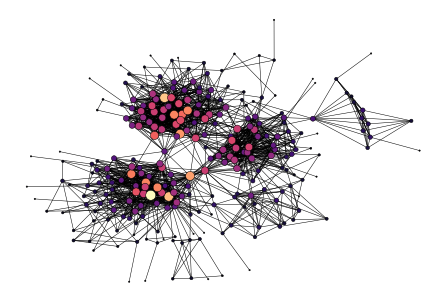

In [35]:
nx.draw(large, 
        pos = nx.kamada_kawai_layout(large),
        width=0.5,
        linewidths=0.5,
        edgecolors='black',
        cmap=plt.cm.magma,
        node_size=np.array(list(nx.algorithms.centrality.degree_centrality(large).values()))*500,
        node_color=np.array(list(nx.algorithms.centrality.degree_centrality(large).values())))
plt.show()

In [39]:
c = {k: v for k, v in sorted(nx.algorithms.centrality.degree_centrality(large).items(), 
                         key=lambda item: item[1], reverse=True)}
list(c)[:5]

[82071205, 98439600, 51690977, 68340598, 70769694]

In [43]:
#Top 5 are 82071205: 0.2007722007722008,
 #98439600: 0.1776061776061776,
 #51690977: 0.17374517374517376,
 #68340598: 0.16216216216216217,
#70769694: 0.15830115830115832,

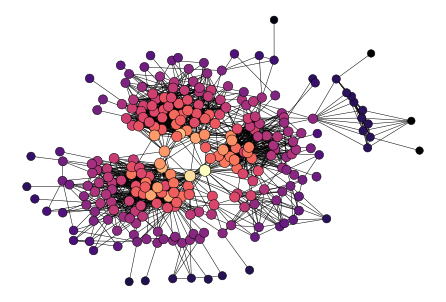

[236297512, 68340598, 70769694, 66830362, 51690977]

In [40]:
nx.draw(large, 
        pos = nx.kamada_kawai_layout(large),
        width=0.5,
        linewidths=0.5,
        edgecolors='black',
        cmap=plt.cm.magma,
        node_size=np.array(list(nx.algorithms.centrality.closeness_centrality(large).values()))*300,
        node_color=np.array(list(nx.algorithms.centrality.closeness_centrality(large).values())))
plt.show()
c = {k: v for k, v in sorted(nx.algorithms.centrality.closeness_centrality(large).items(), 
                         key=lambda item: item[1], reverse=True)}
list(c)[:5]

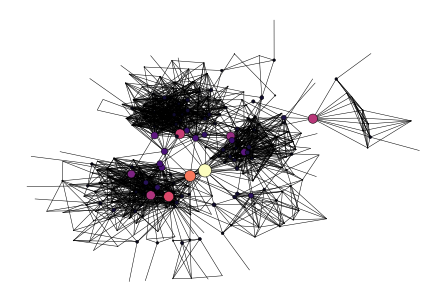

[236297512, 68340598, 51690977, 70769694, 26663918]

In [41]:
nx.draw(large, 
        pos = nx.kamada_kawai_layout(large),
        width=0.5,
        linewidths=0.5,
        edgecolors='black',
        cmap=plt.cm.magma,
        node_size=np.array(list(nx.algorithms.centrality.betweenness_centrality(large).values()))*900,
        node_color=np.array(list(nx.algorithms.centrality.betweenness_centrality(large).values())))
plt.show()
c = {k: v for k, v in sorted(nx.algorithms.centrality.betweenness_centrality(large).items(), 
                         key=lambda item: item[1], reverse=True)}
list(c)[:5]

In [42]:
pr = nx.pagerank(large, alpha=0.9)

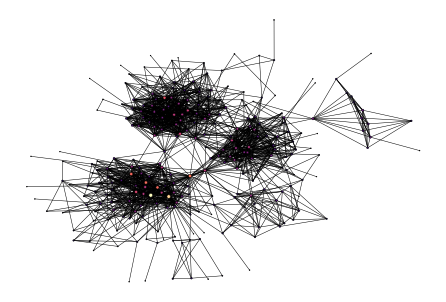

[82071205, 51690977, 68340598, 42841392, 206048055]

In [43]:
nx.draw(large, 
        pos = nx.kamada_kawai_layout(large),
        width=0.5,
        linewidths=0.5,
        edgecolors='black',
        cmap=plt.cm.magma,
        node_size=np.array(list(nx.pagerank(large, alpha=0.9).values()))*900,
        node_color=np.array(list(nx.pagerank(large, alpha=0.9).values())))
plt.show()
c = {k: v for k, v in sorted(nx.pagerank(large, alpha=0.9).items(), 
                         key=lambda item: item[1], reverse=True)}
list(c)[:5]

In [44]:
def katz_centrality(G: nx.Graph, n: int, beta: float) -> np.array:
    """
    Calculate Katz centrality
    
    :param G: graph of Moscow undeground
    :param n: number of iterations in Katz centrality calcultation
    :param beta: attenuation factor
    :return: array of centrality values for each node
    """
    adjacency = nx.to_numpy_array(G, dtype=int)
    if beta >= 1/np.max(np.linalg.eigvals(adjacency)):
        raise Exception('Beta too large')
    centr = np.zeros((len(list(G.nodes)),1))
    for i in range(n):
        centr = centr + (beta**(i+1))*np.linalg.matrix_power(adjacency, i+1).sum(axis=1, keepdims=True)
    centr = centr.reshape(centr.shape[0])
    return centr

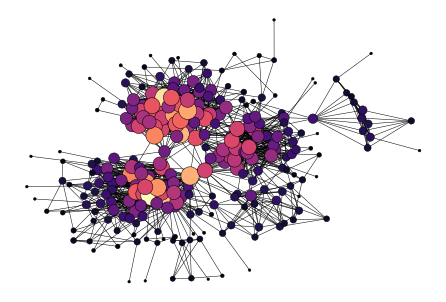

In [45]:
katz_c = katz_centrality(large, 20, 1/100)
katz_c = katz_c / katz_c.max()
nx.draw(large, 
        pos = nx.kamada_kawai_layout(large),
        width=0.5,
        linewidths=0.5,
        edgecolors='black',
        cmap=plt.cm.magma,
        node_size=np.array(katz_c*400),
        node_color=np.array(katz_c))
plt.show()


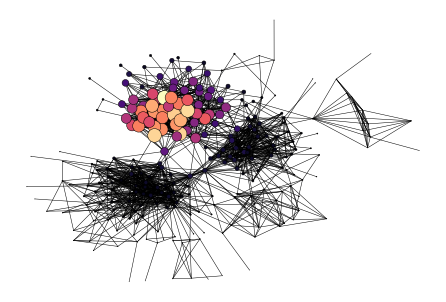

[98439600, 184532587, 178472167, 70769694, 13965101]

In [46]:
nx.draw(large, 
        pos = nx.kamada_kawai_layout(large),
        width=0.5,
        linewidths=0.5,
        edgecolors='black',
        cmap=plt.cm.magma,
        node_size=np.array(list(nx.algorithms.centrality.eigenvector_centrality(large).values()))*900,
        node_color=np.array(list(nx.algorithms.centrality.eigenvector_centrality(large).values())))
plt.show()
c = {k: v for k, v in sorted(nx.algorithms.centrality.eigenvector_centrality(large).items(), 
                         key=lambda item: item[1], reverse=True)}
list(c)[:5]

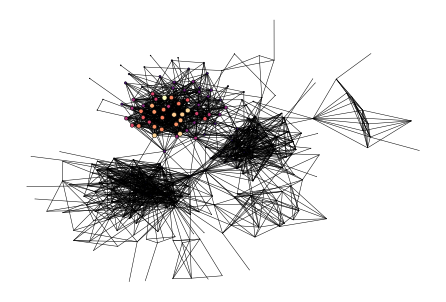

[98439600, 184532587, 178472167, 70769694, 13965101]

In [47]:
nx.draw(large, 
        pos = nx.kamada_kawai_layout(large),
        width=0.5,
        linewidths=0.5,
        edgecolors='black',
        cmap=plt.cm.magma,
        node_size=np.array(list(nx.hits(large)[0].values()))*900,
        node_color=np.array(list(nx.hits(large)[0].values())))
plt.show()
c = {k: v for k, v in sorted(nx.hits(large)[0].items(), 
                         key=lambda item: item[1], reverse=True)}
list(c)[:5]

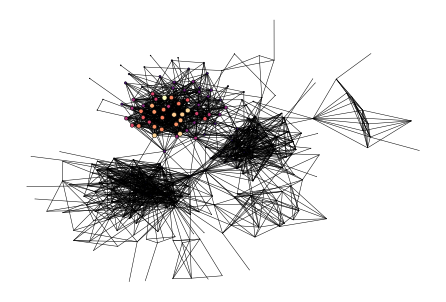

[98439600, 184532587, 178472167, 70769694, 13965101]

In [48]:
nx.draw(large, 
        pos = nx.kamada_kawai_layout(large),
        width=0.5,
        linewidths=0.5,
        edgecolors='black',
        cmap=plt.cm.magma,
        node_size=np.array(list(nx.hits(large)[1].values()))*900,
        node_color=np.array(list(nx.hits(large)[1].values())))
plt.show()
c = {k: v for k, v in sorted(nx.hits(large)[1].items(), 
                         key=lambda item: item[1], reverse=True)}
list(c)[:5]

In [53]:
c = nx.hits(large)
list(c[1])[:5]

[155584, 6176984, 6214725, 6454605, 8473264]

## Community Detection <br>
Clique search, k-cores visualization and interpretation.<br>
Best results of various community detection algorithms, both in terms of interpretation and some quality criterion (modularity, silhouette, ground truth partition).<br>
The results should be visible on the network layout.<br>
Interpretations should be written over image with community detection (use Paint, for e.g.)<br>

In [54]:
def k_core_decompose(G):
    return np.array(list(nx.core_number(G).values()))

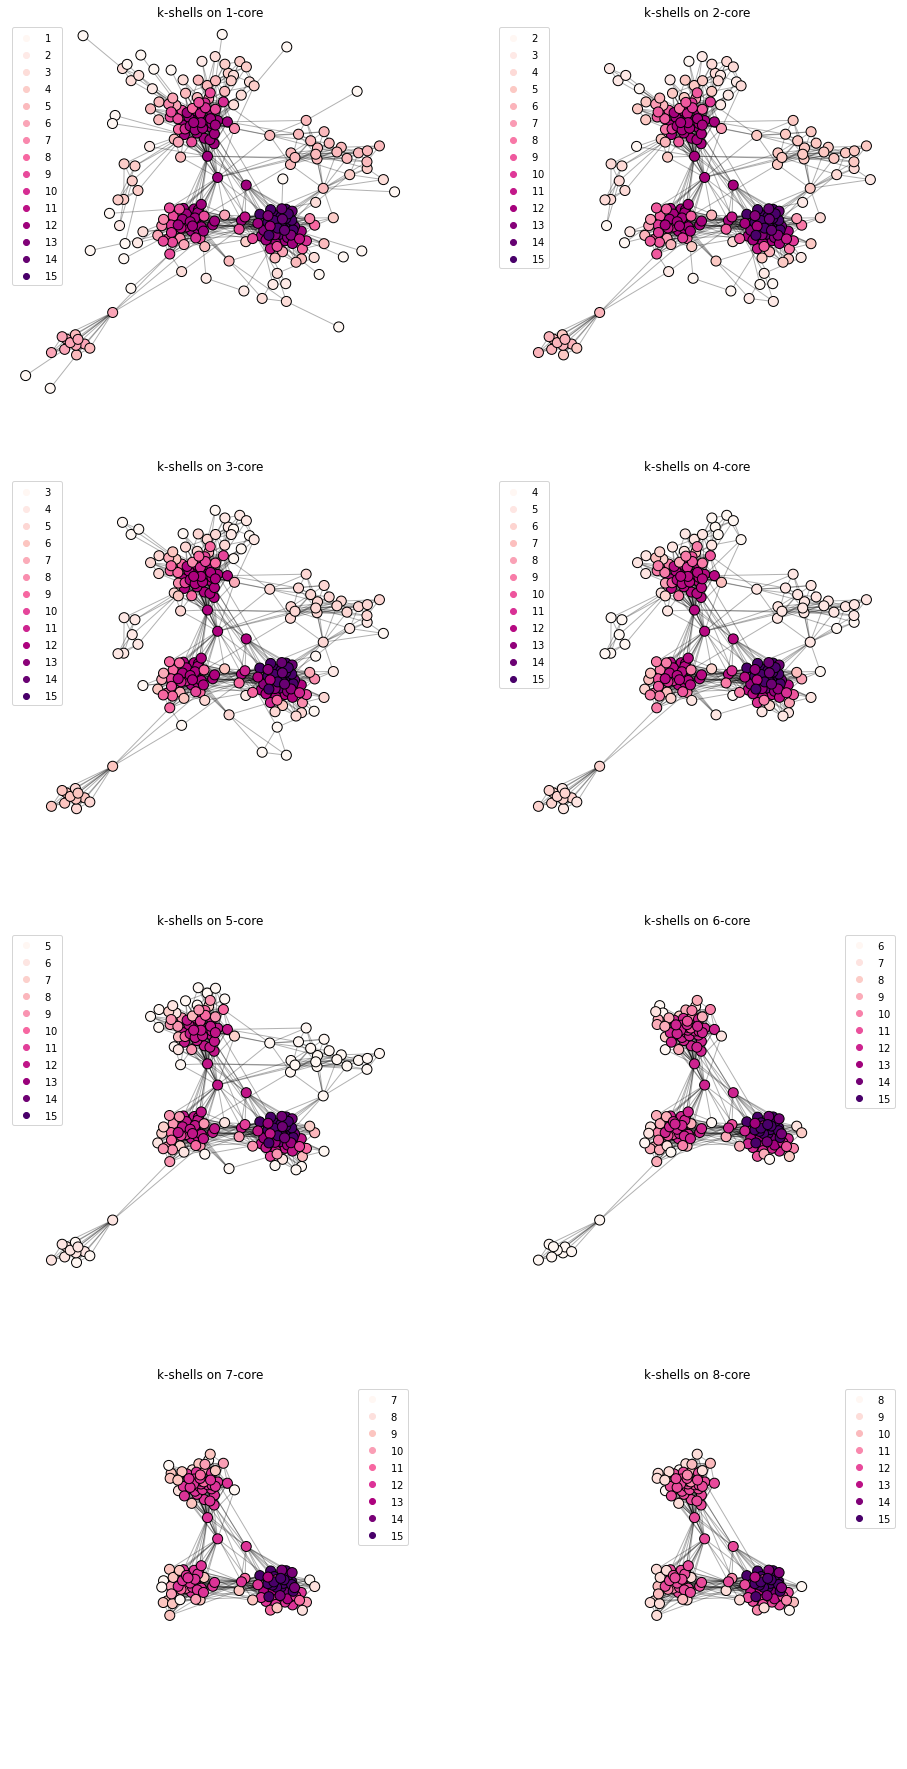

In [55]:
plt.figure(figsize=(8*2, 8*4))

x_max, y_max = np.array(list(pos.values())).max(axis=0)
x_min, y_min = np.array(list(pos.values())).min(axis=0)

for i in range(8):
    plt.subplot(4, 2, i+1)
    subG = nx.k_core(large, i+1)
    nodes = nx.draw_networkx_nodes(
        subG, 
        pos,
        cmap=plt.cm.RdPu,
        node_color=k_core_decompose(subG), 
        node_size=100, 
        edgecolors='black'
    )
    nx.draw_networkx_edges(
        subG, 
        pos,
        alpha=0.3,
        width=1, 
        edge_color='black'
    )
    eps = (x_max - x_min) * 0.05
    plt.xlim(x_min-eps, x_max+eps)
    plt.ylim(y_min-eps, y_max+eps)
    plt.legend(*nodes.legend_elements())
    plt.axis('off')
    plt.title('k-shells on {}-core'.format(i+1))

In [56]:
cliques = list(nx.find_cliques(large))

In [57]:
cliques.sort(key=len, reverse=True)

In [58]:
def largest_cliques(G):
    cliques = sorted(nx.find_cliques(G),key=len,reverse=True)
    k = 0
    C, W = [], []
    for clique in cliques:
        if len(clique) < k:
            break
        else:
            k = len(clique)
        color_list = []
        for node in list(G.nodes):
            if node in clique:
                rgb = [1,0,0]
            else:
                rgb = [1,1,1]
            color_list.append(rgb)
        width_list = []
        for i, j in list(G.edges):
            if (i in clique) and (j in clique):
                width = 2
            else:
                width = 1
            width_list.append(width)
        C.append(color_list)
        W.append(width_list)
    C = np.array(C)
    W = np.array(W)
    return C, W

In [59]:
colors, widths = largest_cliques(large)
size = np.unique(colors[0], axis=0, return_counts=True)[1][0]

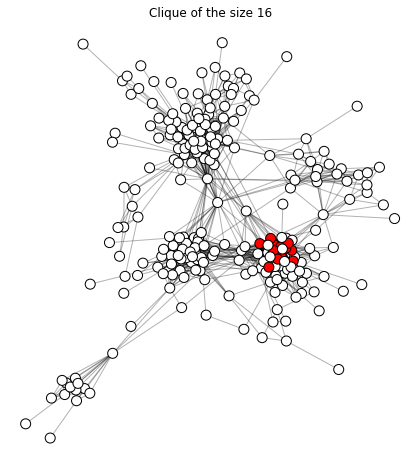

In [60]:
plt.figure(figsize=(8*2, 8))

for i in range(colors.shape[0]):
    
    b_edges = np.array(list(large.edges))[widths[i] == widths[i].max()]
    
    plt.subplot(1, 2, i+1)
    nodes = nx.draw_networkx_nodes(
        large, 
        pos,
        node_color=colors[i], 
        node_size=100, 
        linewidths=1, 
        edgecolors='black'
    )
    nx.draw_networkx_edges(
        large,
        pos,
        alpha=0.3,
        width=widths[i].min()
    )
    nx.draw_networkx_edges(
        large,
        pos,
        width=widths[i].max(),
        edgelist=b_edges
    )
    plt.title('Clique of the size {}'.format(size))
    plt.axis('off')

In [61]:
cliques[0]

[70769694,
 98439600,
 13965101,
 178472167,
 184532587,
 12600247,
 103029926,
 28033257,
 145354098,
 128191770,
 135392571,
 52058370,
 146572228,
 70400207,
 265141736,
 39106517]

In [62]:
#Girvan Newman algorithm
def edge_betweenness(G, n):
    Gcopy = G.copy()
    curr_cc_count = nx.number_connected_components(Gcopy)
    result = []
    while curr_cc_count <= n:
        edge_btw = nx.edge_betweenness_centrality(Gcopy)
        cut_edge = sorted(edge_btw.keys(), key=lambda x : edge_btw[x])[-1]
        Gcopy.remove_edge(*cut_edge)
        if (nx.number_connected_components(Gcopy) > curr_cc_count):
            iter_result = np.zeros((Gcopy.number_of_nodes()))
            for idx, cc in enumerate(nx.connected_components(Gcopy)):
                iter_result[np.isin(G.nodes, list(cc))] = idx
            result.append(iter_result)
            curr_cc_count += 1
    return np.array(result)

In [63]:
labels = edge_betweenness(large, 4)

In [64]:
labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 1., 1.],
       [0., 1., 0., ..., 0., 1., 1.],
       [0., 1., 0., ..., 0., 1., 1.]])

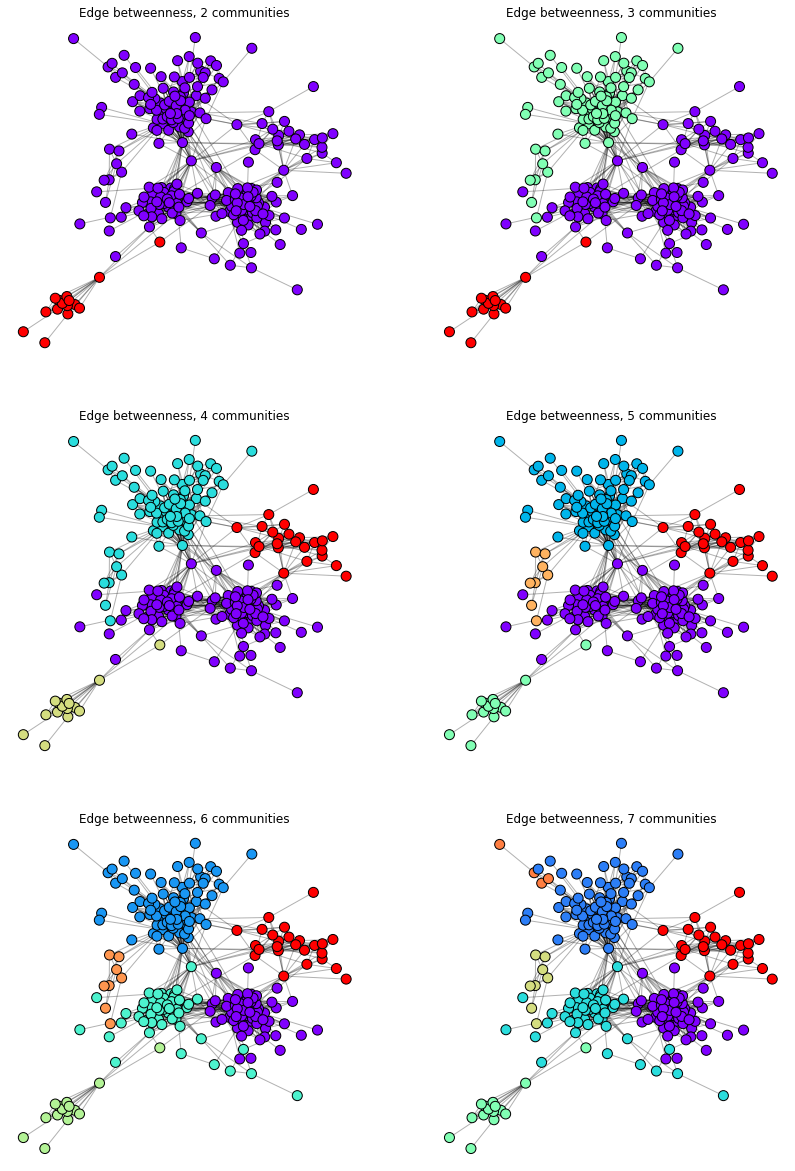

In [65]:
plt.figure(figsize=(7*2, 7*3))
colors = edge_betweenness(large, 6)
for i in range(colors.shape[0]):
    plt.subplot(3, 2, i+1)
    nx.draw_networkx_nodes(
        large, 
        pos,
        cmap=plt.cm.rainbow,
        node_color=colors[i], 
        node_size=100, 
        edgecolors='black'
    )
    nx.draw_networkx_edges(large, pos, alpha=0.3)
    plt.title('Edge betweenness, {} communities'.format(i+2))
    plt.axis('off')

In [66]:
def edge_betw_modularity(G, n):
    res = []
    comm_gen = nx.algorithms.community.girvan_newman(G)
    for i in range(n):
        part = next(comm_gen)
        res.append(nx.algorithms.community.modularity(G, part))
    return np.array(res)

In [67]:
n_iterations = 20
modularity = edge_betw_modularity(large, n_iterations)

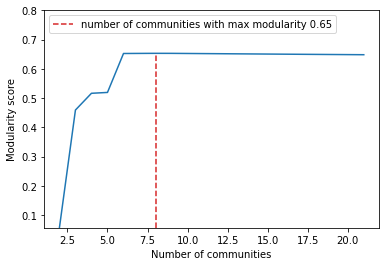

In [68]:
#plt.figure(figsize=(12, 8))
plt.plot(np.arange(n_iterations)+2, modularity)
best_n = np.argmax(modularity) + 2
label = 'number of communities with max modularity {:.2f}'.format(max(modularity))
plt.plot(
    [best_n, best_n], [min(modularity), max(modularity)], 
    'k--', c='tab:red', 
    label=label
)
plt.ylabel('Modularity score')
plt.xlabel('Number of communities')
plt.legend(loc='upper left')
plt.ylim((modularity.min(), 0.8))
plt.show()

In [69]:
coms = nx.algorithms.community.asyn_fluid.asyn_fluidc(large, 7)

In [70]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(large))

In [71]:
len(c)

7

In [72]:
def greedy(G):
    from networkx.algorithms.community import greedy_modularity_communities
    cliques = list(greedy_modularity_communities(G))
    k = 0
    C, W = [], []
    for clique in cliques:
        if len(clique) < k:
            break
        else:
            k = len(clique)
        color_list = []
        for node in list(G.nodes):
            if node in clique:
                rgb = [1,0,0]
            else:
                rgb = [1,1,1]
            color_list.append(rgb)
        width_list = []
        for i, j in list(G.edges):
            if (i in clique) and (j in clique):
                width = 2
            else:
                width = 1
            width_list.append(width)
        C.append(color_list)
        W.append(width_list)
    C = np.array(C)
    W = np.array(W)
    return C, W

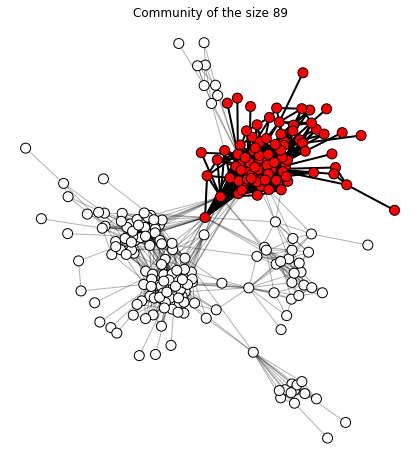

In [81]:
colors, widths = greedy(large)
size = np.unique(colors[0], axis=0, return_counts=True)[1][0]
plt.figure(figsize=(8*2, 8))

for i in range(colors.shape[0]):
    
    b_edges = np.array(list(large.edges))[widths[i] == widths[i].max()]
    
    plt.subplot(1, 2, i+1)
    nodes = nx.draw_networkx_nodes(
        large, 
        pos,
        node_color=colors[i], 
        node_size=100, 
        linewidths=1, 
        edgecolors='black'
    )
    nx.draw_networkx_edges(
        large,
        pos,
        alpha=0.3,
        width=widths[i].min()
    )
    nx.draw_networkx_edges(
        large,
        pos,
        width=widths[i].max(),
        edgelist=b_edges
    )
    plt.title('Community of the size {}'.format(size))
    plt.axis('off')

In [73]:
def fluid(G):
    cliques = sorted(list(nx.algorithms.community.asyn_fluid.asyn_fluidc(G, 7)), key=len, reverse=True)

    k = 0
    C, W = [], []
    for clique in cliques:
        if len(clique) < k:
            break
        else:
            k = len(clique)
        color_list = []
        for node in list(G.nodes):
            if node in clique:
                rgb = [0,0,1]
            else:
                rgb = [1,1,1]
            color_list.append(rgb)
        width_list = []
        for i, j in list(G.edges):
            if (i in clique) and (j in clique):
                width = 2
            else:
                width = 1
            width_list.append(width)
        C.append(color_list)
        W.append(width_list)
    C = np.array(C)
    W = np.array(W)
    return C, W

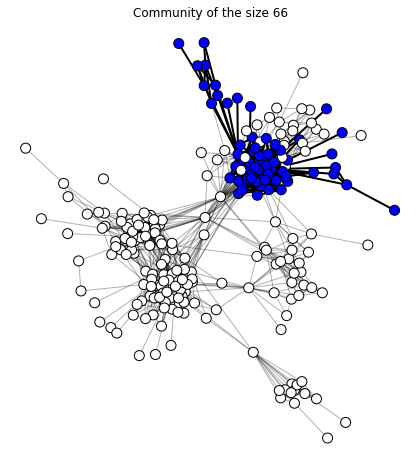

In [90]:
colors, widths = fluid(large)
size = np.unique(colors[0], axis=0, return_counts=True)[1][0]
plt.figure(figsize=(8*2, 8))

for i in range(colors.shape[0]):
    
    b_edges = np.array(list(large.edges))[widths[i] == widths[i].max()]
    
    plt.subplot(1, 2, i+1)
    nodes = nx.draw_networkx_nodes(
        large, 
        pos,
        node_color=colors[i], 
        node_size=100, 
        linewidths=1, 
        edgecolors='black'
    )
    nx.draw_networkx_edges(
        large,
        pos,
        alpha=0.3,
        width=widths[i].min()
    )
    nx.draw_networkx_edges(
        large,
        pos,
        width=widths[i].max(),
        edgelist=b_edges
    )
    plt.title('Community of the size {}'.format(size))
    plt.axis('off')